# Week 6

This week, we continue improving neural networks by considering two different issues:

* Vanishing and Exploding Gradients -- when gradients of different layers vary tremendously, resulting in poor learning
* Keras -- the Keras library offers an easy way to deploy TensorFlow-based models that can exploit GPUs

# Lecture 11 - Sept 28 - Vanishing and Exploding Gradients

**Deep** neural networks (i.e. models with many hidden layers) offer an opportunity to learn much more complex patterns in high-dimensional data. However, training deep networks presents some challenges. It is difficult to maintain gradients throughout the network that allow the many parameters of the model to learn in an effective manner.

In particular, we have learned that backpropagation starts with the output layer where the loss is computed, and propagates the loss backward through the network, computing the partial derivatives with respect to the weights just before the output layer, then weights in the previous layer, and the previous layer, and so on, until we reach the weights coming from the input layer. Recall, the partial derivatives propagate backwards as

$$\delta^l=\left(\left(w^{l+1}\right)^T\delta^{l+1}\right) \odot \sigma'\left(z^l\right)$$

where $\sigma$ is a common activation function for each neuron. This indicates the partial derivatives for weights in layer $l$ are the partial derivatives in layer $l+1$ multiplied by several terms.

Mathematically speaking, each partial derivative is constructed by repeated multiplication, with earlier layers made up of products of more terms. Repeated multiplication is inherently pretty unstable:

* If just one term nears 0, the whole product might **vanish** to 0
* If just one term grows a lot, the whole product might **explode** to a high value

In other words, the gradients are at risk to vanish or explode during the training process.

If the partial derivatives for the earlier weights vanish (go to 0), these weights will have gradient-based weight updates near 0, meaning the weights get stuck. Hence, the corresponding weights do not learn anything and our (expensive) backprop calculations cost a lot of time without yielding benefits.

If the partial derivatives for any weights explore (get very large), these weights will have huge gradient-based weight updates, sending the weights to large values. Note that backpropagation involves multiplications by the weights, causing the gradients to get even larger leading the model to blow up and cause overflows.

In the first case, the model may learn, but we waste computation. In the second case, the model doesn't converge at all. In both cases, deep nets can fail to live up to their potential.

**See more details on this issue and mitigating it in class.**

# Lecture 12 - Sept 30 - Using Keras

Since computation is a bottleneck for neural nets, it is worthwhile to learn to construct neural nets with a dedicated deep learning framework rather than simply raw Python with NumPy, as we have used so far, because they allow highly optimized computation accelerated by graphics processing units (GPUs) and let us create nets quickly and easily.

As of now, the most popular solutions are probably Facebook's PyTorch and Google's TensorFlow with Keras. (There are some other solutions like Theano, Caffe, and MXNet as well.) Both have two main parts: (1) highly optimized tensor computing, including matrix multiplication and (2) simple functionality for creating neural networks with optimized backpropagation.

We only use TensorFlow + Keras in the class, but it is good to know these other options exist.

## Writing a Fully-connected Feedforward Neural Net with Keras

We will aim to write a neural net similar to what we have constructed through the course so far. That is, it should feed data forward through a sequence of layers, the layers should be fully connected (dense), and we should use SGD to optimize it. We can import these things directly from Keras.

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import scale

Let's construct the net to classify MNIST (our beloved benchmarking dataset).

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_11 (Dense)             (None, 10)                1290      
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 3s 47us/sample - loss: 0.0906 - accuracy: 0.1482 - val_loss: 0.0889 - val_accuracy: 0.2844
Epoch 2/100
60000/60000 [==============================] - 2s 31us/sample - loss: 0.0882 - accuracy: 0.2516 - val_loss: 0.0872 - val_accuracy: 0.2817
Epoch 3/100
60000/60000 [===

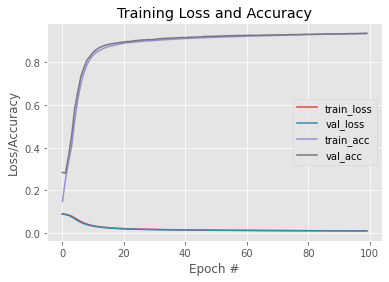

In [5]:
# Create a feedforward neural net
model = Sequential()

# Create the layers
model.add(Dense(256, activation = "sigmoid", input_shape=(784,))) # hidden layer 1
model.add(Dense(128, activation = "sigmoid")) # hidden layer 2
model.add(Dense(10, activation = "sigmoid")) # output layer

model.compile(loss = "mean_squared_error", optimizer = SGD(0.5), metrics = ["accuracy"])

model.build()
model.summary()

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### CLASSIFY MNIST PICTURES

# create a dataset of 1000 MNIST images, reshaped as single vectors, and labels

((trainX, trainY), (testX, testY)) = mnist.load_data()

trainX = trainX.reshape((trainX.shape[0], 28 * 28 * 1))
testX = testX.reshape((testX.shape[0], 28 * 28 * 1))

trainX = trainX/255.0
testX = testX/255.0

lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

# fit the model to the training data
maxEpoch = 100
H = model.fit(trainX, trainY, validation_data=(testX, testY), epochs = maxEpoch, batch_size = 128)

print("Validation accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX, batch_size = 128)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)

print(classification_report(testY, predictedY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, maxEpoch), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, maxEpoch), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, maxEpoch), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxEpoch), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

Let's try a more modern version using ReLU and softmax layers with categorical crossentropy loss, the ADAM optimizer, and elastic-net regularization.

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 2s 41us/sample - loss: 1.2278 - accuracy: 0.7215 - val_loss: 0.6101 - val_accuracy: 0.8666
Epoch 2/100
60000/60000 [==============================] - 2s 32us/sample - loss: 0.5297 - accuracy: 0.8778 - val_loss: 0.4417 - val_accuracy: 0.8994
Epoch 3/100
60000/60000 [==============================] - 2s 32us/sample - loss: 0.4317 - accuracy: 0.8979 - val_loss: 0.3860 - val_accuracy: 0.9090
Epoch 4/100
60000/60000 [==============================] - 2s 32us/sample - loss: 0.3892 - accuracy: 0.9079 - val_loss: 0.3593 - val_accuracy: 0.9156
Epoch 5/100
60000/60000 [==============================] - 2s 32us/sample - loss: 0.3620 - accuracy: 0.9148 - val_loss: 0.3366 - val_accuracy: 0.9217
Epoch 6/100
60000/60000 [==============================] - 2s 32us/sample - loss: 0.3419 - accuracy: 0.9199 - val_loss: 0.3197 - val_accuracy: 0.9267
Epoch 7/100
60000/60000 [=========================

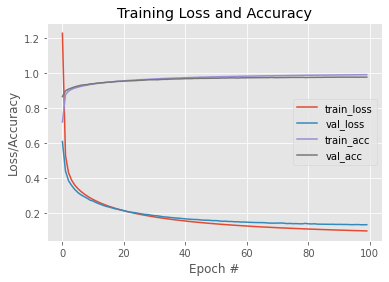

In [7]:
# Create a feedforward neural net
model = Sequential()

# Create the first hidden layer
model.add(Dense(256, input_shape = (784,), activation = "relu", kernel_regularizer = l1_l2(l1 = 0.0, l2 = 0.0001)))
model.add(Dense(128, activation = "relu", kernel_regularizer = l1_l2(l1 = 0.0, l2 = 0.0001)))
model.add(Dense(10, activation = "softmax", kernel_regularizer = l1_l2(l1 = 0.0, l2 = 0.0001)))

model.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics = ["accuracy"])

### CLASSIFY MNIST PICTURES

# create a dataset of 1000 MNIST images, reshaped as single vectors, and labels

((trainX, trainY), (testX, testY)) = mnist.load_data()

trainX = trainX.reshape((trainX.shape[0], 28 * 28 * 1))
testX = testX.reshape((testX.shape[0], 28 * 28 * 1))

trainX = trainX/255.0
testX = testX/255.0

lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

# fit the model to the training data
H = model.fit(trainX, trainY, validation_data=(testX, testY), epochs = 100, batch_size = 128)

print("Validation accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX, batch_size = 128)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)

print(classification_report(testY, predictedY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 100), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 100), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

As expected, this is a little better. Just like our own code, Keras can easily be applied to CIFAR-10 or any other dataset with datapoints of the same size.

[INFO] training network...
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 8s 160us/sample - loss: 1.8788 - accuracy: 0.3208 - val_loss: 1.7292 - val_accuracy: 0.3798
Epoch 2/100
50000/50000 [==============================] - 7s 135us/sample - loss: 1.7021 - accuracy: 0.3919 - val_loss: 1.6841 - val_accuracy: 0.4019
Epoch 3/100
50000/50000 [==============================] - 7s 132us/sample - loss: 1.6387 - accuracy: 0.4160 - val_loss: 1.6350 - val_accuracy: 0.4168
Epoch 4/100
50000/50000 [==============================] - 7s 136us/sample - loss: 1.5931 - accuracy: 0.4322 - val_loss: 1.5887 - val_accuracy: 0.4350
Epoch 5/100
50000/50000 [==============================] - 8s 158us/sample - loss: 1.5635 - accuracy: 0.4426 - val_loss: 1.5649 - val_accuracy: 0.4406
Epoch 6/100
50000/50000 [==============================] - 7s 134us/sample - loss: 1.5456 - accuracy: 0.4483 - val_loss: 1.5559 - val_accuracy: 0.4475
Epoch 7/100
50000

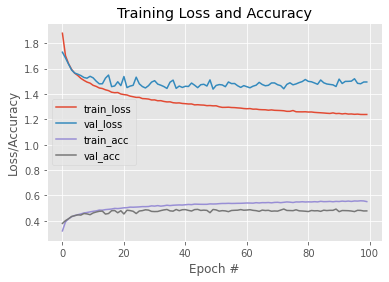

In [20]:
# load the training and testing data, scale it into the range [0, 1],
# then reshape the design matrix
((trainX, trainY), (testX, testY)) = cifar10.load_data()

trainX = trainX/255.0
testX = testX/255.0

trainX = trainX.reshape((trainX.shape[0], 3072))
testX = testX.reshape((testX.shape[0], 3072))

# convert the labels from integers to vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

# initialize the label names for the CIFAR-10 dataset
labelNames = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# define the 3072-128-64-10 architecture using Keras
model = Sequential()
model.add(Dense(128, input_shape=(3072,), activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(10, activation="softmax"))

#opt = SGD(lr=0.5, momentum=0.5)
model.compile(loss="categorical_crossentropy", optimizer = 'adam', metrics = ["accuracy"])

# train the model using SGD
print("[INFO] training network...")
H = model.fit(trainX, trainY, validation_data=(testX, testY), epochs = 100, batch_size = 32)

# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size = 32)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 100), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 100), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

As we will see, sometimes the simpler tools just do a better job!

[INFO] training network...
Train on 50000 samples, validate on 10000 samples
Epoch 1/1000
50000/50000 [==============================] - 17s 346us/sample - loss: 0.0923 - accuracy: 0.1324 - val_loss: 0.0898 - val_accuracy: 0.1678
Epoch 2/1000
50000/50000 [==============================] - 16s 316us/sample - loss: 0.0897 - accuracy: 0.1778 - val_loss: 0.0896 - val_accuracy: 0.2092
Epoch 3/1000
50000/50000 [==============================] - 13s 269us/sample - loss: 0.0895 - accuracy: 0.2098 - val_loss: 0.0894 - val_accuracy: 0.2100
Epoch 4/1000
50000/50000 [==============================] - 15s 292us/sample - loss: 0.0892 - accuracy: 0.2182 - val_loss: 0.0891 - val_accuracy: 0.2227
Epoch 5/1000
50000/50000 [==============================] - 17s 333us/sample - loss: 0.0889 - accuracy: 0.2264 - val_loss: 0.0887 - val_accuracy: 0.2323
Epoch 6/1000
50000/50000 [==============================] - 15s 307us/sample - loss: 0.0884 - accuracy: 0.2359 - val_loss: 0.0881 - val_accuracy: 0.2476
Epoch

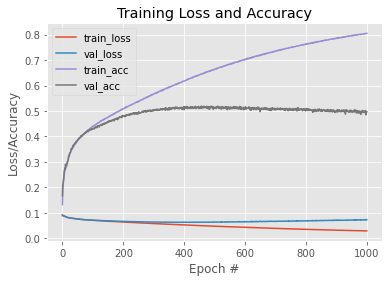

In [23]:
# load the training and testing data, scale it into the range [0, 1],
# then reshape the design matrix
((trainX, trainY), (testX, testY)) = cifar10.load_data()

trainX = trainX/255.0
testX = testX/255.0

trainX = trainX.reshape((trainX.shape[0], 3072))
testX = testX.reshape((testX.shape[0], 3072))

# convert the labels from integers to vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

# initialize the label names for the CIFAR-10 dataset
labelNames = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# define the 3072-128-64-10 architecture using Keras
model = Sequential()
model.add(Dense(128, input_shape=(3072,), activation="sigmoid"))
model.add(Dense(64, activation="sigmoid"))
model.add(Dense(10, activation="sigmoid"))

# train the model using SGD
print("[INFO] training network...")
opt = SGD(lr=0.05, momentum=0.5)
model.compile(loss="mean_squared_error", optimizer = opt, metrics = ["accuracy"])
maxIt = 1000
H = model.fit(trainX, trainY, validation_data=(testX, testY), epochs = maxIt, batch_size = 32)

# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size = 32)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, maxIt), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, maxIt), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, maxIt), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

It's also simple to implement different initializers, regularizers, etc.

[INFO] training network...
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 11s 215us/sample - loss: 0.0958 - accuracy: 0.1387 - val_loss: 0.0925 - val_accuracy: 0.1580
Epoch 2/100
50000/50000 [==============================] - 8s 168us/sample - loss: 0.0924 - accuracy: 0.1780 - val_loss: 0.0923 - val_accuracy: 0.2035
Epoch 3/100
50000/50000 [==============================] - 7s 149us/sample - loss: 0.0922 - accuracy: 0.2039 - val_loss: 0.0920 - val_accuracy: 0.2111
Epoch 4/100
50000/50000 [==============================] - 8s 169us/sample - loss: 0.0918 - accuracy: 0.2049 - val_loss: 0.0916 - val_accuracy: 0.2199
Epoch 5/100
50000/50000 [==============================] - 8s 169us/sample - loss: 0.0913 - accuracy: 0.2109 - val_loss: 0.0910 - val_accuracy: 0.2112
Epoch 6/100
50000/50000 [==============================] - 9s 171us/sample - loss: 0.0906 - accuracy: 0.2124 - val_loss: 0.0902 - val_accuracy: 0.2052
Epoch 7/100
5000

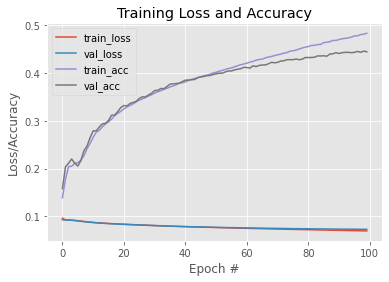

In [9]:
from tensorflow.keras.initializers import RandomUniform
from sklearn.preprocessing import scale

# load the training and testing data, scale it into the range [0, 1],
# then reshape the design matrix
((trainX, trainY), (testX, testY)) = cifar10.load_data()

trainX = trainX.reshape((trainX.shape[0], 3072))
testX = testX.reshape((testX.shape[0], 3072))

trainX = trainX/255.0
testX = testX/255.0

trainX = scale(trainX)
testX = scale(testX)

# convert the labels from integers to vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

# initialize the label names for the CIFAR-10 dataset
labelNames = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# define the 3072-1024-512-10 architecture using Keras
model = Sequential()
model.add(Dense(128, input_shape=(3072,), kernel_initializer = RandomUniform(minval=-0.1, maxval=0.1),
                bias_initializer = RandomUniform(minval=-0.1, maxval=0.1),
                kernel_regularizer = l1_l2(l1 = 0.0, l2 = 0.1/50000), bias_regularizer = l1_l2(l1 = 0.0, l2 = 0.1/50000),
                activation="sigmoid"))

model.add(Dense(64, kernel_initializer = RandomUniform(minval=-0.1, maxval=0.1),
                kernel_regularizer = l1_l2(l1 = 0.0, l2 = 0.1/50000), bias_regularizer = l1_l2(l1 = 0.0, l2 = 0.1/50000),
                bias_initializer = RandomUniform(minval=-0.1, maxval=0.1), activation="sigmoid"))

model.add(Dense(10, kernel_initializer = RandomUniform(minval=-0.1, maxval=0.1),
                bias_initializer = RandomUniform(minval=-0.1, maxval=0.1),
                kernel_regularizer = l1_l2(l1 = 0.0, l2 = 0.1/50000), bias_regularizer = l1_l2(l1 = 0.0, l2 = 0.1/50000),
                activation="sigmoid"))

# train the model using SGD
print("[INFO] training network...")
opt = SGD(lr=0.05, momentum=0.5)
model.compile(loss="mean_squared_error", optimizer = opt, metrics = ["accuracy"])
maxIt = 100
H = model.fit(trainX, trainY, validation_data=(testX, testY), epochs = maxIt, batch_size = 32)

# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size = 32)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, maxIt), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, maxIt), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, maxIt), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

Keras also provides some nice tools to print out a summary of the model or even an image file of the network architecture.

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 256)               200960    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 10)                1290      
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 6s 1

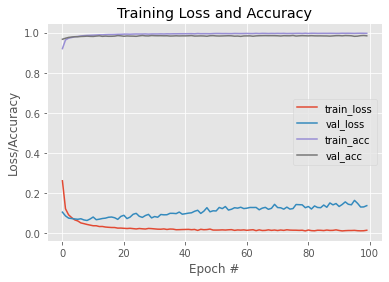

In [15]:
# Create a feedforward neural net
model = Sequential()

# Create the layers

model.add(Dense(256, activation = "relu", input_shape=(784,))) # hidden layer 1
model.add(Dropout(0.2))
model.add(Dense(128, activation = "relu")) # hidden layer 2
model.add(Dropout(0.2))
model.add(Dense(10, activation = "softmax")) # output layer

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ["accuracy"])

model.build()

# print out some details about the model
model.summary()

# save a png file showing the net's layers with details
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# load the training and testing data, scale it into the range [0, 1],
# then reshape the design matrix

((trainX, trainY), (testX, testY)) = mnist.load_data()

trainX = trainX.reshape((trainX.shape[0], 28 * 28 * 1))
testX = testX.reshape((testX.shape[0], 28 * 28 * 1))

trainX = trainX/255.0
testX = testX/255.0

lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

# fit the model to the training data
maxEpoch = 100
H = model.fit(trainX, trainY, validation_data=(testX, testY), epochs = maxEpoch, batch_size = 32)

print("Validation accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX, batch_size = 128)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)

print(classification_report(testY, predictedY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, maxEpoch), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, maxEpoch), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, maxEpoch), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxEpoch), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

A couple of features we learned about but never implemented in class are built into Keras, such as dropout (for regularization) and the ADAM optimizer, which adapts the learning rates to each parameter in an often-effective way.

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 256)               200960    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 10)                1290      
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________
Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 3s 5

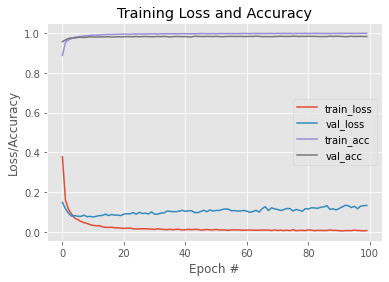

In [17]:
# load the training and testing data, scale it into the range [0, 1],
# then reshape the design matrix

((trainX, trainY), (testX, testY)) = mnist.load_data()

trainX = trainX.reshape((trainX.shape[0], 28 * 28 * 1))
testX = testX.reshape((testX.shape[0], 28 * 28 * 1))

trainX = trainX/255.0
testX = testX/255.0

lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

# Create a feedforward neural net
model = Sequential()

# Create the layers
model.add(Dense(256, activation = "relu", input_shape=(trainX.shape[1],))) # hidden layer 1
model.add(Dropout(0.2))
model.add(Dense(128, activation = "relu")) # hidden layer 2
model.add(Dropout(0.2))
model.add(Dense(10, activation = "softmax")) # output layer

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ["accuracy"])

model.build()
model.summary()

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# fit the model to the training data
maxEpoch = 100
H = model.fit(trainX, trainY, validation_split = 0.2, epochs = maxEpoch, batch_size = 128)

print("[INFO] Test set performance")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX, batch_size = 32)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)

print(classification_report(testY, predictedY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, maxEpoch), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, maxEpoch), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, maxEpoch), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, maxEpoch), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()